In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from scipy.stats import chisquare
from collections import OrderedDict


In [39]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [40]:
def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

In [41]:
def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

In [42]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-100
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [43]:
def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400
    cut2=cut-50
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]


    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi

In [44]:
def gaus(x,x0,sigma,a,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c

In [45]:
PATH = '/Users/austinmcdonald/Desktop/XeHe/Data/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

['/Users/austinmcdonald/Desktop/XeHe/Data/085/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/090/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/093/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/095/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/096/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/097/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/098/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/099/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/100/']

In [46]:
folders = 

'095'

In [47]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
for F in range(0,len(folders)):
    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(Data[0])!=0:
            xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
        
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct

Xe-085_P-10_E-080.txt
Xe-085_P-10_E-100.txt
Xe-085_P-10_E-150.txt
Xe-085_P-10_E-200.txt
Xe-085_P-10_E-250.txt
Xe-085_P-10_E-300.txt
Xe-085_P-10_E-350.txt
Xe-090_P-01_E-080.txt
Xe-090_P-01_E-100.txt
Xe-090_P-01_E-150.txt
Xe-090_P-01_E-200.txt
Xe-090_P-01_E-250.txt
Xe-090_P-01_E-300.txt
Xe-090_P-10_E-080.txt
Xe-090_P-10_E-100.txt
Xe-090_P-10_E-150.txt
Xe-090_P-10_E-200.txt
Xe-090_P-10_E-250.txt
Xe-090_P-10_E-300.txt
Xe-090_P-10_E-350.txt
Xe-093_P-10_E-080.txt
Xe-093_P-10_E-100.txt
Xe-093_P-10_E-150.txt
Xe-093_P-10_E-200.txt
Xe-093_P-10_E-250.txt
Xe-093_P-10_E-300.txt
Xe-093_P-10_E-350.txt
Xe-095_P-01_E-080.txt
Xe-095_P-01_E-100.txt
Xe-095_P-01_E-150.txt
Xe-095_P-01_E-200.txt
Xe-095_P-01_E-250.txt
Xe-095_P-01_E-300.txt
Xe-095_P-10_E-080.txt
Xe-095_P-10_E-100.txt
Xe-095_P-10_E-150.txt
Xe-095_P-10_E-200.txt
Xe-095_P-10_E-250.txt
Xe-095_P-10_E-300.txt
Xe-095_P-10_E-350.txt
Xe-096_P-03_E-080.txt
Xe-096_P-03_E-100.txt
Xe-096_P-03_E-150.txt
Xe-096_P-03_E-200.txt
Xe-096_P-03_E-250.txt
Xe-096_P-0

In [48]:
len(GOLDD)

9

In [85]:
DlStar = dict()
Vel = dict()
SigmaA = []
SigmaG = []
for q in range(0,len(GOLDD)):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    gig = ((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    SigmaA.append(sig.tolist())
    SigmaG.append(gig.tolist())
    #sig = ((ANODE[:,1]*1e6))**2 

    dd = 13.49*1e4
    Dlong = sig*0.5*dd**2/Dt**3

    Vd = 13.49/Dt
    Vel[q] = 134.9/Dt
    Dlstar = np.sqrt(2*Dlong/Vd)*np.sqrt(PRE[q])*np.sqrt(273/296)
    DlStar[q] = Dlstar

In [86]:
SigmaG = [item for sublist in SigmaG for item in sublist]
SigmaA = [item for sublist in SigmaA for item in sublist]

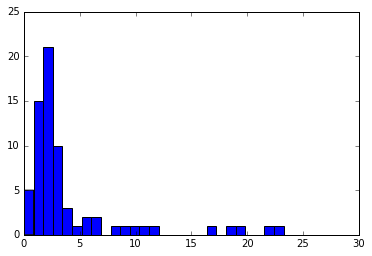

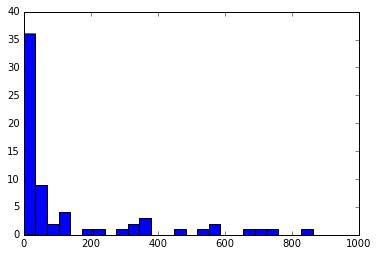

In [98]:
bb = np.linspace(0,25,30)
plt.hist(SigmaG,bins=bb)
plt.show()


bb = np.linspace(0,1e3,30)
plt.hist(SigmaA,bins=bb)
plt.show()

In [110]:
MBZ = np.load("/Users/austinmcdonald/Desktop/MB-XeAr-Dl.npy")

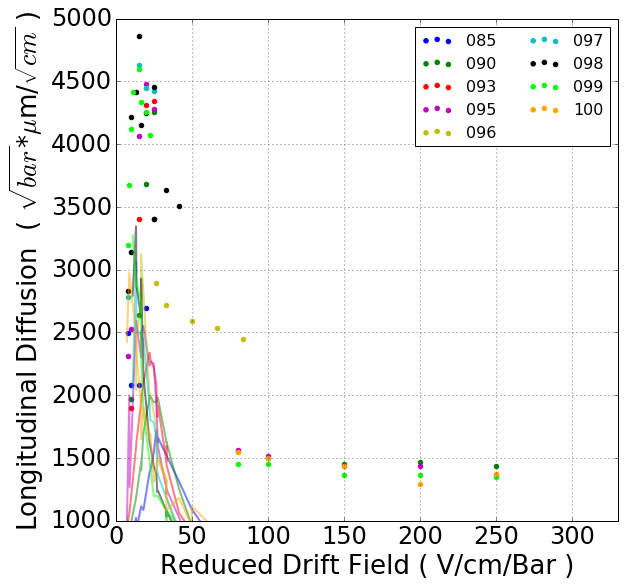

In [100]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],DlStar[q],color=COL[q],label=PERCT[q])
for q in range(0,len(GOLDD)):
    eh1 =q*2
    eh2 =q*2+1
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(1e3,5e3)
plt.xlim(0,330)
plt.show()

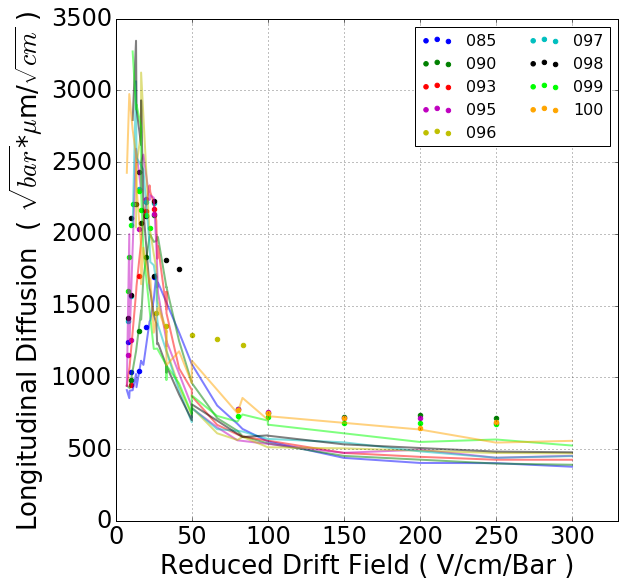

In [101]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],DlStar[q]/2,color=COL[q],label=PERCT[q])
    eh1 =q*2
    eh2 =q*2+1
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,3500)
plt.xlim(0,330)
plt.show()

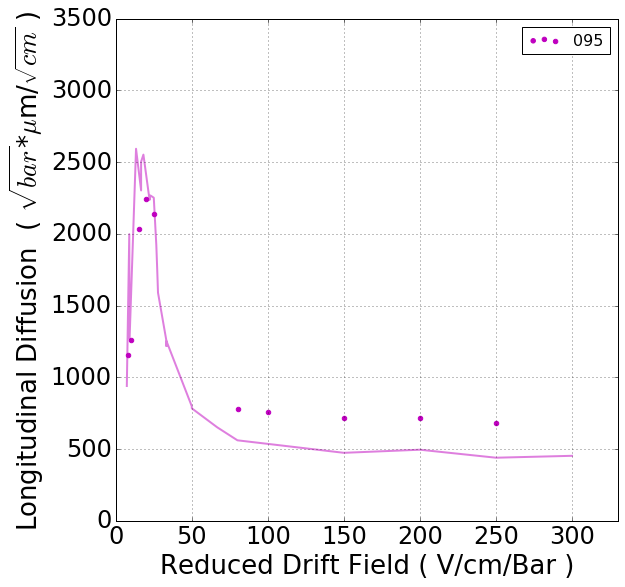

In [125]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue']
plt.figure(figsize=(9,9))
for q in [3]:
    plt.scatter(REDU[q],DlStar[q]/2,color=COL[q],label=PERCT[q])
    eh1 =q*2
    eh2 =q*2+1
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,3500)
plt.xlim(0,330)
plt.show()

In [102]:
MBZ = np.load("/Users/austinmcdonald/Desktop/MB-XeAr.npy")

In [103]:
PERCT

{0: '085',
 1: '090',
 2: '093',
 3: '095',
 4: '096',
 5: '097',
 6: '098',
 7: '099',
 8: '100'}

In [104]:
[0,1,2,3,5,7]

[0, 1, 2, 3, 5, 7]

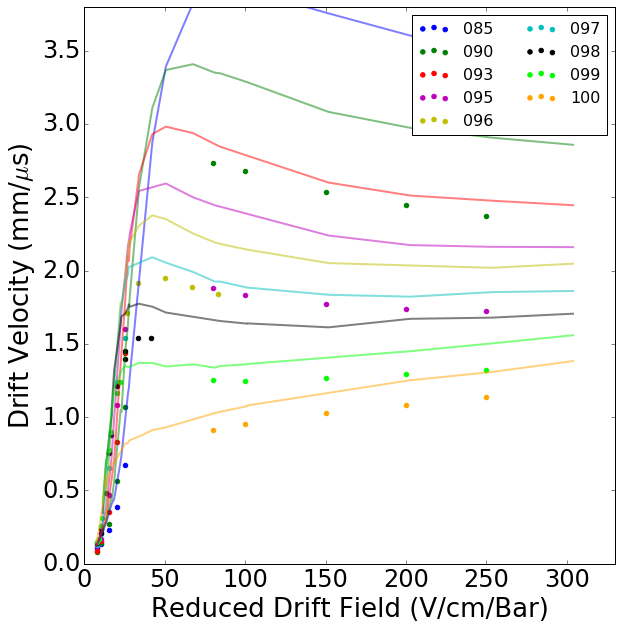

In [106]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=PERCT[q])
    eh1 =q*2
    eh2 =q*2+1
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)


plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)
plt.tight_layout()

plt.grid()
plt.ylim(0,3.8)
plt.xlim(0,330)
plt.show()

In [32]:
Dt = (ANODE[:,0] - GOLDD[:,0])*1e6
sig = ((ANODE[:,1]*1e6))**2 -((GOLDD[:,1]*1e6))**2
#sig = ((ANODE[:,1]*1e6))**2 

dd = 13.49*1e4
Dlong = sig*0.5*dd**2/Dt**3

Vd = 13.49/Dt

DlStar = np.sqrt(2*Dlong/Vd)*np.sqrt(PRE)*np.sqrt(273/296)


In [35]:
xx = np.array([  79.94740302,   99.93425378,  149.90138067,  199.86850756,
        249.83563445,  299.80276134,   26.64913434,   33.31141793,
         49.96712689,   66.62283585,   83.27854482,   99.93425378,
         13.32456717,   16.65570896,   24.98356345,   33.31141793,
         41.63927241,   49.96712689,    8.88304478,   11.10380598,
         16.65570896,   22.20761195,   27.75951494,   33.31141793,
          7.26794573,    9.08493216,   13.62739824,   18.16986432,
         22.7123304 ,   27.25479649])
yy = np.array([  627.49431081,   539.49537807,   452.28070318,   426.11409999,
         398.84913567,   390.68044993,  1950.1145821 ,  1627.09175263,
         961.11402784,   715.55146161,   590.36443497,   539.49643067,
        1181.11587407,  1466.21264021,  1944.2260609 ,  1627.09168289,
        1252.33370881,   961.11365456,     0.        ,     0.        ,
        1401.9319344 ,  1979.68489099,  1975.67557279,  1629.24767244,
         942.8914575 ,   925.41373169,     0.        ,  1699.05524527,
        1994.22244958,  1981.95353727])

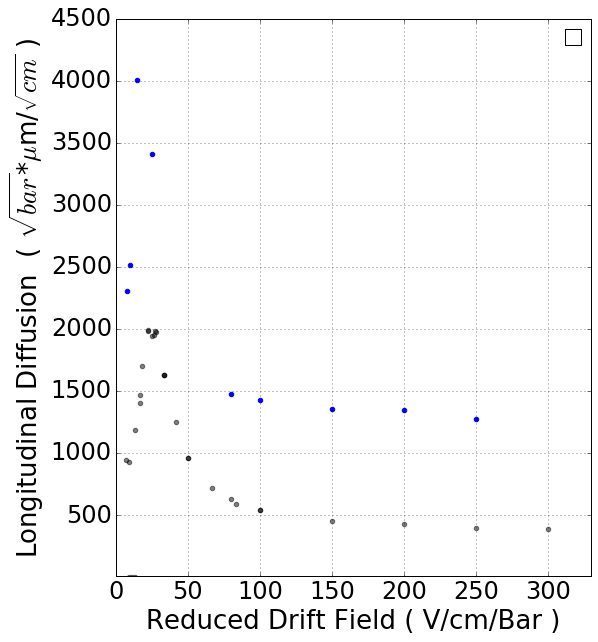

In [40]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
#plt.scatter(REDU,DlStar/2.2,color='r')
plt.scatter(REDU,DlStar,color='b')
plt.scatter(xx,yy,color='k',alpha=0.5)


plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
legend2=plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=1,fontsize=20)


plt.gca().add_artist(legend2)

plt.tight_layout()
plt.xlim(0,330)
plt.ylim(10,4500)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/"+'lon-MyData.png')
plt.show()

In [294]:
xx =np.array([22.854850598683974,28.451871561612315,25.976097587285608,26.319397001186584,28.014994067095756,
    28.519560605515803,29.997258279098197,33.05297364352235,33.95935960591133,38.01773578799755,
    37.9184944806012,38.25720937758441,41.933991945633025,43.51618963719392,44.248768472906406,
    47.63214195821797,48.660556973859265,53.69206429110784,57.135441012548995])
yy = np.array([1359.8234511524215, 1319.460824853475, 1212.1804322030848, 1166.3406565747364, 1159.099816619323, 1200.6031785983962
    , 1107.4538851533564, 1055.756714968897, 1029.9377943979, 1129.9827406421919, 983.9254251914708, 986.773219229801
    , 939.3423465535218, 936.4028621768364, 956.4156269102153, 1024.9892129013697, 903.2217467908381, 868.6140376110171
    , 899.9532559059364])

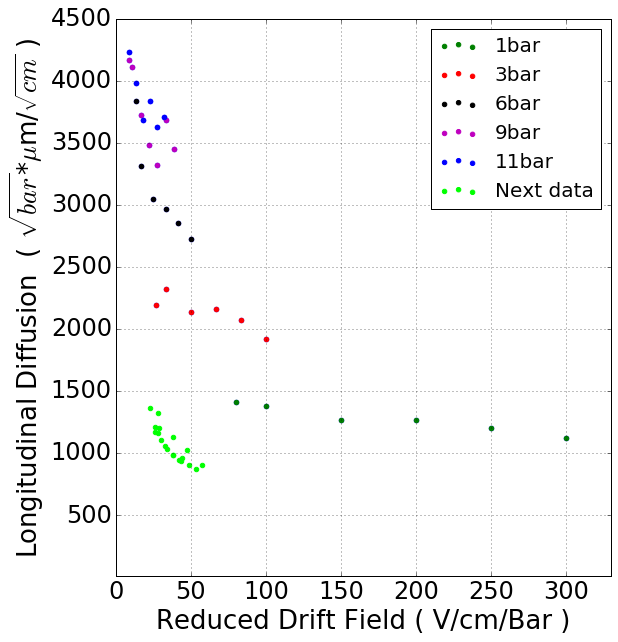

In [295]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
plt.scatter(REDU,DlStar,color='b')
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],DlStar[x],color=col[1],label='1bar')
    if PRE[x]==3:
        plt.scatter(REDU[x],DlStar[x],color=col[2],label='3bar')
    if PRE[x]==6:
        plt.scatter(REDU[x],DlStar[x],color=col[3],label='6bar')
    if PRE[x]==9:
        plt.scatter(REDU[x],DlStar[x],color=col[4],label='9bar')
    if PRE[x]==11:
        plt.scatter(REDU[x],DlStar[x],color=col[0],label='11bar')
        
plt.scatter(xx,yy,color='lime',label='Next data')

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
legend2=plt.legend(by_label.values(), by_label.keys(),loc='upper right',ncol=1,fontsize=20)


plt.gca().add_artist(legend2)

plt.tight_layout()
plt.xlim(0,330)
plt.ylim(10,4500)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/"+'lon-MyData.png')
plt.show()

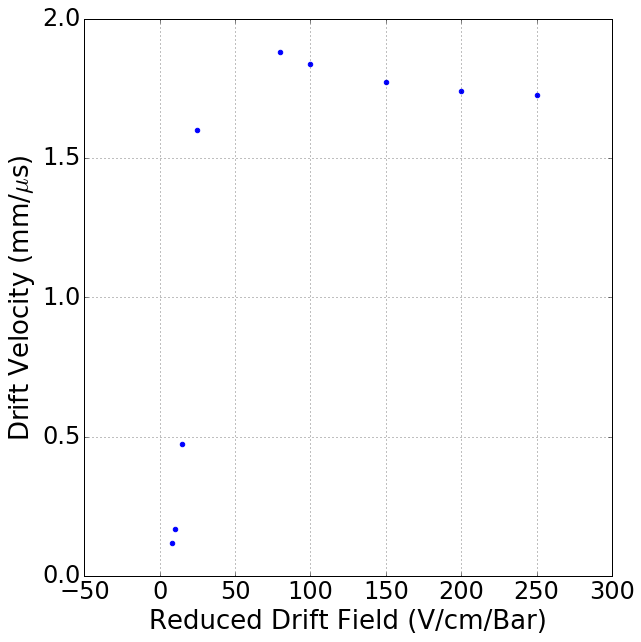

In [41]:
Vd = 134.9/Dt
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
#plt.scatter(REDU,DlStar/2.2,color='r')
plt.scatter(REDU,Vd,color='b')



plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
#plt.legend(loc='upper right',fontsize=16,ncol=2)
plt.tight_layout()

In [334]:
Dt = (ANODE[:,0] - GOLDD[:,0])*1e6

d = 13.8
Vd = d/Dt
x = 2*Dt/Vd**2
y = (ANODE[:,1]*1e6)**2-(GOLDD[:,1]*1e6)**2
#y = ((ANODE[:,1]*1e6)-(GOLDD[:,1]*1e6))**2

Dl = y/x
Mu = Vd/EFID
ddd = d**2*y/(2*Dt**3)
dddd = np.sqrt((273/296*2*PP)*ddd*1e8/Vd)

In [335]:
#difff =np.sqrt((273/296*.95*2*PP)*Dl*1e8/Vd)
#difff =np.sqrt(Dl*1e8/Vd)

##Zp =12.123*(289.77/273.15)*(PRE/57.65) 
#Z0 = 0.22308122
#difff =np.sqrt((Z0/Zp*2*PRE)*Dl*1e8/Vd)
difff = np.sqrt((273/296*2*PP)*Dl*1e8/Vd)
#difff = np.sqrt(Dl*1e8/PP)

difff

array([ 5859.1812881 ,  6607.70784405,  6071.67447692,  6727.65135827,
        6594.92280153,  4628.54848418,  5746.46076076,  7110.1208406 ,
        6712.07503552,  6564.46705705,  6229.55264868,  5025.18203253,
        7476.78346103,  8946.25070281,  6208.5602445 ,  6295.44543733,
        6118.22819892,  6041.03334962,  5814.2811909 ,  5505.54380846,
        6732.76841924,  6270.12509612,  5850.15266883,  6077.05349412,
        5399.33882241,  6284.10014482,  6817.37758802,  6034.62603083,
        5805.34172162,  5305.53490353,  5992.60832365])

In [336]:
PRE

array([ 1,  1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,
        6,  9,  9,  9,  9,  9,  9,  9, 11, 11, 11, 11, 11, 11])

In [340]:
V = 5000 #cm**3
K = 1.38e-23*10000 # cm**2*kg/s**2*k
T = 273.15
P = PRE*1000#1*1e5/10 # Pa  # kg/cm*s**2
n = P/(K*T)
N = n/V
Td = 1e-17

TDX = EFID/N/Td

In [343]:
TDX

array([ 1507.788     ,  1884.735     ,  2827.1025    ,  3769.47      ,
        4711.8375    ,  5654.205     ,   502.596     ,   628.245     ,
         942.3675    ,  1256.49      ,  1570.6125    ,  1884.735     ,
         251.298     ,   314.1225    ,   471.18375   ,   628.245     ,
         785.30625   ,   942.3675    ,   167.532     ,   209.415     ,
         314.1225    ,   418.83      ,   523.5375    ,   628.245     ,
         732.9525    ,   171.33954545,   257.00931818,   342.67909091,
         428.34886364,   514.01863636,   599.68840909])

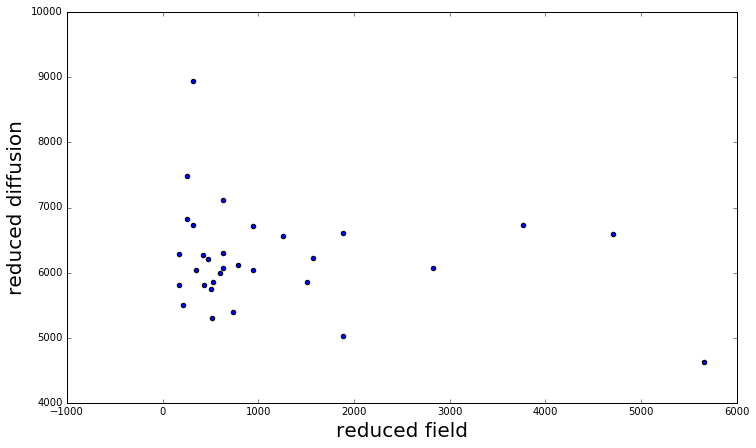

In [342]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
#plt.scatter(REDU,difff)
plt.scatter(TDX,dddd)

#plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])

plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(0,350)
#plt.ylim(5000,10000)

(0, 350)

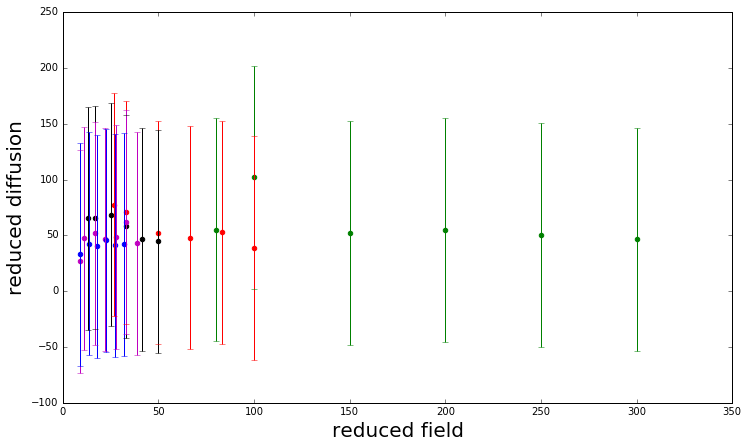

In [411]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],difff[x],color=col[1])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],difff[x],color=col[2])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],difff[x],color=col[3])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],difff[x],color=col[4])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],difff[x],color=col[0])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[0])
plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
#plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(0,350)

(0, 350)

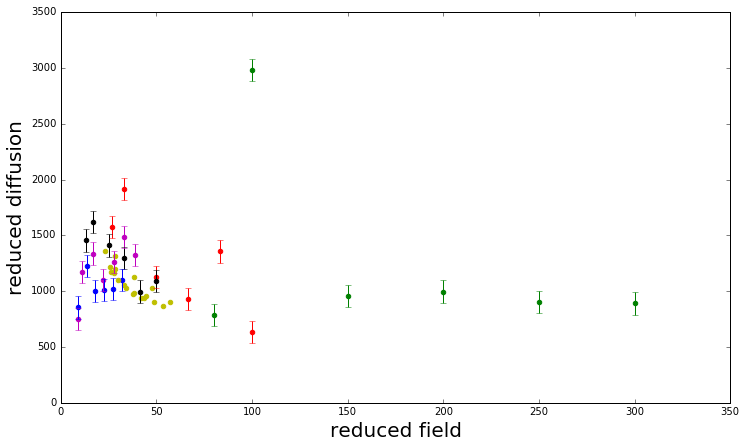

In [242]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],difff[x],color=col[1])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],difff[x],color=col[2])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],difff[x],color=col[3])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],difff[x],color=col[4])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],difff[x],color=col[0])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[0])
plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(0,350)

(50, 370)

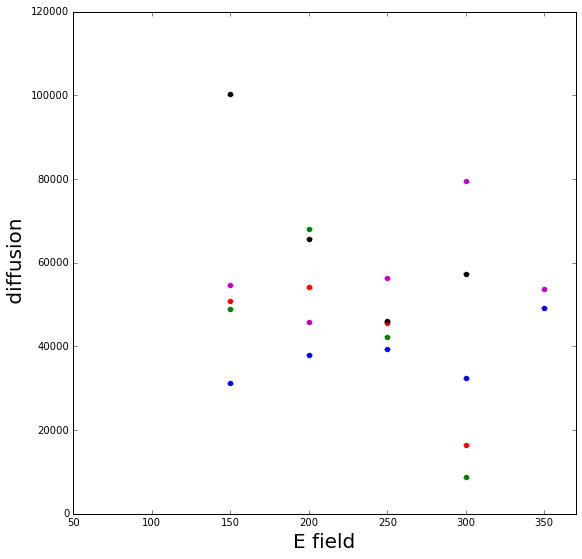

In [261]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[1])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[2])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[3])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[4])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[0])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[0])
        
#plt.scatter(REDU,difff)
plt.xlabel('E field',fontsize=20)
plt.ylabel(' diffusion',fontsize=20)
#plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(50,370)

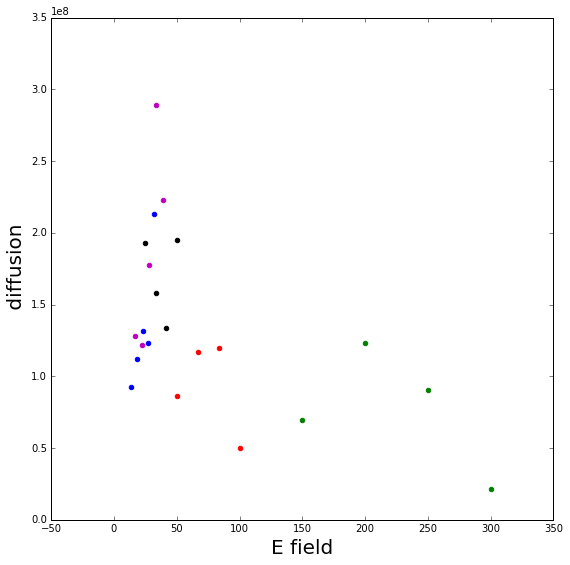

In [262]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[1])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[2])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[3])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[4])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[0])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[0])
        
#plt.scatter(REDU,difff)
plt.xlabel('E field',fontsize=20)
plt.ylabel(' diffusion',fontsize=20)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(50,370)

In [24]:
dd = np.genfromtxt('/Users/austinmcdonald/Desktop/set.csv',delimiter=',')

In [25]:
dd[:,0]

array([ 22.90880631,  28.49373882,  25.98076923,  26.41413238,
        28.55826151,  28.07867133,  29.96202635,  33.18657505,
        34.04756871,  38.06334363,  38.02333713,  38.29094162,
        42.05216295,  43.44738982,  44.35826964,  47.57196292,
        48.54907302,  53.65051228,  57.1358351 ])

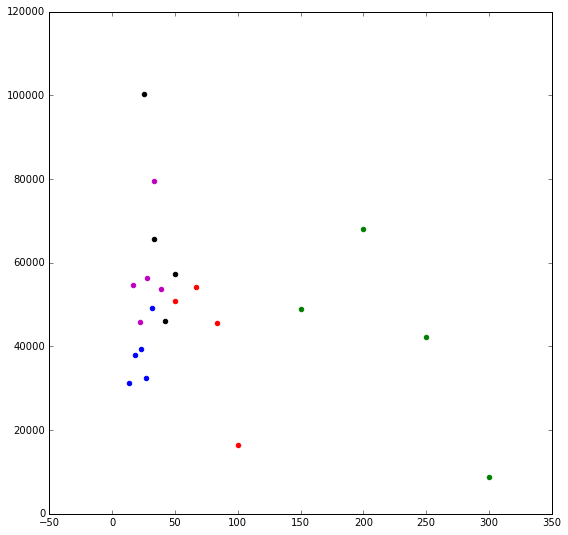

In [266]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[0])
        
#plt.scatter(REDU,difff)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(0,75)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


(0, 0.15)

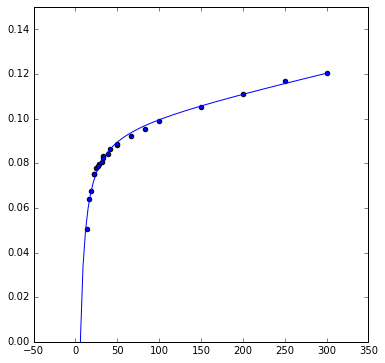

In [251]:
xnew = np.linspace(0,300,100)
def polyy(x,a,b,c):
    #return a*np.sqrt(x)+b+c*x+d
    return -a/x+b +c*x
popt,pcov = optimize.curve_fit(polyy,REDU,Vd)
plt.figure(figsize=(6,6))
plt.plot(xnew,polyy(xnew,*popt))
plt.scatter(REDU,Vd)
plt.ylim(0,0.15)

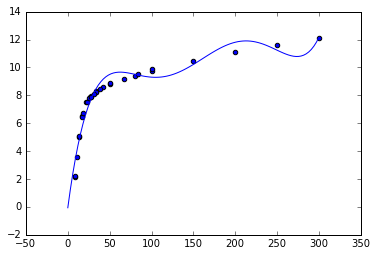

In [84]:
coefs = poly.polyfit(REDU, Vd*100, 5)
xnew = np.linspace(0,300,100)
ffit = poly.polyval(xnew, coefs)

plt.scatter(REDU,Vd*100)
plt.plot(xnew,ffit)

In [ ]:
np.sqrt(273/296*12)*np.sqrt(Dl/Vd)

In [ ]:
np.sqrt(273/296*12)

In [ ]:
####Xe-008_P-01_E-100.txt
#Xe-099_P-0302_E-250.txt
#Xe-099_P-0302_E-040.txt
#Xe-099_P-0901_E-080.txt
#Xe-099_P-0995_E-250.txt
#Xe-099_P-0601_E-250.txt
#Xe-100_P-1080_E-080.txt
#Xe-100_P-0302_E-100.txt
#Xe-100_P-0101_E-100.txt
#Xe-100_P-1080_E-250.txt
#Xe-100_P-0101_E-250.txt
##Xe-100_P-1080_E-300.txt
#Xe-100_P-1080_E-100.txt
#Xe-100_P-0302_E-040.txt
#Xe-100_P-0607_E-300.txt
#Xe-035_P-01_E-080.txt
#Xe-035_P-06_E-200.txt

In [ ]:
Xe-035_P-01_E-080.txt
Xe-035_P-11_E-080.txt
Xe-035_P-06_E-200.txt

In [ ]:
PATH = '/Users/austinmcdonald/Desktop/Xenon/Data/100/'
PP = "Xe-100_P-0909_E-200.txt"
Data = np.loadtxt(PATH+PP)

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(Data[0],Data[1])
X,Y,O = FITTER_GOLD(Data[0],Data[1])
print(O)
plt.plot(X,func(X,*O),color='r')
plt.plot(Data[0],Data[2])
X,Y,O = FITTER_ANOD(Data[0],Data[2])
print(O)
plt.plot(X,func(X,*O),color='r')
#plt.xlim(0,0.001)

In [ ]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
#plt.plot(Data[0],Data[1])
X,Y,O = FITTER_GOLD(Data[0],Data[1])
O

In [ ]:
# arrival, sigma, max, RC
xval = np.linspace(-.0001,0.002,10000)

X,Y,O = FITTER_GOLD(Data[0],Data[1])
plt.plot(xval,gaus(xval,O[2],O[0],O[1]),color='r')
X,Y,O = FITTER_ANOD(Data[0],Data[2])
plt.plot(xval,gaus(xval,O[2],O[0],O[1]),color='g')
plt.xlim(-1e-5,3e-4)

In [ ]:
X,Y,O = FITTER_GOLD(Data[0],Data[1])
plt.plot(xval,gaus(xval,1,0,O[1]),color='r')
print(O[1])
X,Y,O = FITTER_ANOD(Data[0],Data[2])
plt.plot(xval,abs(gaus(xval,1,0,O[1])),color='g')
print(O[1])
plt.xlim(-1e-5,1e-5)

In [ ]:
(7.0303106598e-06-4.75471431319e-06)*1e6


In [ ]:
(6.13364779471e-06)*1e6*13.8